In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
import torch.nn.utils.rnn as rnn_utils
import time
import pickle
from termcolor import colored

In [3]:
def genData(file,max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,
             'L':11,'K':12,'M':13,'F':14,'P':15,'O':16,'S':17,'U':18,'T':19,
             'W':20,'Y':21,'V':22,'X':23}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
        
    long_pep_counter=0
    pep_codes=[]
    labels=[]
    for pep in lines:
        pep,label=pep.split(",")
        labels.append(int(label))
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(torch.tensor(current_pep))
        else:
            long_pep_counter += 1
    print("length > 81:",long_pep_counter)
    data = rnn_utils.pad_sequence(pep_codes,batch_first=True)
    return data,torch.tensor(labels)


In [4]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        acc_sum += (outputs.argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

def to_log(log):
    with open("../compareModel/2021ACS_PepFormer/modelLog.log","a+") as f:
        f.write(log+'\n')

In [5]:
def collate(batch):
    seq1_ls=[]
    seq2_ls=[]
    label1_ls=[]
    label2_ls=[]
    label_ls=[]
    batch_size=len(batch)
    for i in range(int(batch_size/2)):
        seq1,label1=batch[i][0],batch[i][1]
        seq2,label2=batch[i+int(batch_size/2)][0],batch[i+int(batch_size/2)][1]
        label1_ls.append(label1.unsqueeze(0))
        label2_ls.append(label2.unsqueeze(0))
        label=(label1^label2)
        seq1_ls.append(seq1.unsqueeze(0))
        seq2_ls.append(seq2.unsqueeze(0))
        label_ls.append(label.unsqueeze(0))
    seq1=torch.cat(seq1_ls).to(device)
    seq2=torch.cat(seq2_ls).to(device)
    label=torch.cat(label_ls).to(device)
    label1=torch.cat(label1_ls).to(device)
    label2=torch.cat(label2_ls).to(device)
    return seq1,seq2,label,label1,label2

# New Train

# 1. Make Data X_train, y_train, X_test, y_test

In [7]:
data,label=genData("../compareModel/2021ACS_PepFormer/dataset/Homo_sapiens.csv",81)
print(data.shape,label.shape)

train_data,train_label=data[:70000],label[:70000]
test_data,test_label=data[70000:],label[70000:]

train_dataset = Data.TensorDataset(train_data, train_label)
test_dataset = Data.TensorDataset(test_data, test_label)

batch_size=256
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_iter_cont = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                                                  shuffle=True, collate_fn=collate)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

length > 81: 0
torch.Size([90000, 79]) torch.Size([90000])


# 2. train

In [8]:
device = torch.device("cuda",0)

In [9]:
class newModel(nn.Module):
    def __init__(self, vocab_size=24):
        super().__init__()
        self.hidden_dim = 25
        self.batch_size = 256
        self.emb_dim = 512
        
        self.embedding = nn.Embedding(vocab_size, self.emb_dim, padding_idx=0)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        
        self.gru = nn.GRU(self.emb_dim, self.hidden_dim, num_layers=2, 
                               bidirectional=True, dropout=0.2)
        
        
        self.block1=nn.Sequential(nn.Linear(4050,1024),
                                            nn.BatchNorm1d(1024),
                                            nn.LeakyReLU(),
                                            nn.Linear(1024,256),
                                 )

        self.block2=nn.Sequential(
                                               nn.BatchNorm1d(256),
                                               nn.LeakyReLU(),
                                               nn.Linear(256,128),
                                               nn.BatchNorm1d(128),
                                               nn.LeakyReLU(),
                                               nn.Linear(128,64),
                                               nn.BatchNorm1d(64),
                                               nn.LeakyReLU(),
                                               nn.Linear(64,2)
                                            )
        
    def forward(self, x):
        x=self.embedding(x)
        output=self.transformer_encoder(x).permute(1, 0, 2)
        output,hn=self.gru(output)
        output=output.permute(1,0,2)
        hn=hn.permute(1,0,2)
        output=output.reshape(output.shape[0],-1)
        
        hn=hn.reshape(output.shape[0],-1)
        output=torch.cat([output,hn],1)
#         print(output.shape, hn.shape)
        return self.block1(output)

    def trainModel(self, x):
        with torch.no_grad():
            output=self.forward(x)
        return self.block2(output)


class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # euclidean_distance: [128]
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +     # calmp夹断用法
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))     
        
        return loss_contrastive

In [11]:
for num_model in range(1):
    net=newModel().to(device)
    lr = 0.0001
    optimizer = torch.optim.Adam(net.parameters(), lr=lr,weight_decay=5e-4)
    criterion = ContrastiveLoss()
    criterion_model = nn.CrossEntropyLoss(reduction='sum')
    best_acc=0
    EPOCH=250
    for epoch in range(EPOCH):
        loss_ls=[]
        loss1_ls=[]
        loss2_3_ls=[]
        t0=time.time()
        net.train()
        for seq1,seq2,label,label1,label2 in train_iter_cont:
                output1=net(seq1)
                output2=net(seq2)
                output3=net.trainModel(seq1)
                output4=net.trainModel(seq2)
                loss1=criterion(output1, output2, label)
                loss2=criterion_model(output3,label1)
                loss3=criterion_model(output4,label2)
                loss=loss1+loss2+loss3
    #             print(loss)
                optimizer.zero_grad() 
                loss.backward()
                optimizer.step()
                loss_ls.append(loss.item())
                loss1_ls.append(loss1.item())
                loss2_3_ls.append((loss2+loss3).item())


        net.eval() 
        with torch.no_grad(): 
            train_acc=evaluate_accuracy(train_iter,net)
            test_acc=evaluate_accuracy(test_iter,net)
        results=f"epoch: {epoch+1}, loss: {np.mean(loss_ls):.5f}, loss1: {np.mean(loss1_ls):.5f}, loss2_3: {np.mean(loss2_3_ls):.5f}\n"
        results+=f'\ttrain_acc: {train_acc:.4f}, test_acc: {colored(test_acc,"red")}, time: {time.time()-t0:.2f}'
        print(results)
#         to_log(results)
        if test_acc>best_acc:
            best_acc=test_acc
#             torch.save({"best_acc":best_acc,"model":net.state_dict()},f'./Model/{num_model}.pl')
            print(f"best_acc: {best_acc}")

epoch: 1, loss: 179.49525, loss1: 2.51021, loss2_3: 176.98504
	train_acc: 0.5602, test_acc: 0.557, time: 35.93
best_acc: 0.557
epoch: 2, loss: 172.71200, loss1: 1.02709, loss2_3: 171.68491
	train_acc: 0.6019, test_acc: 0.60275, time: 36.14
best_acc: 0.60275
epoch: 3, loss: 152.66300, loss1: 1.00927, loss2_3: 151.65373
	train_acc: 0.7281, test_acc: 0.7263, time: 36.35
best_acc: 0.7263
epoch: 4, loss: 136.49091, loss1: 0.97324, loss2_3: 135.51767
	train_acc: 0.7323, test_acc: 0.7325, time: 36.31
best_acc: 0.7325
epoch: 5, loss: 132.55767, loss1: 0.95647, loss2_3: 131.60120
	train_acc: 0.7468, test_acc: 0.74935, time: 36.56
best_acc: 0.74935
epoch: 6, loss: 130.13147, loss1: 0.94320, loss2_3: 129.18827
	train_acc: 0.7478, test_acc: 0.7438, time: 36.41
epoch: 7, loss: 129.67819, loss1: 0.94165, loss2_3: 128.73654
	train_acc: 0.7601, test_acc: 0.75915, time: 36.60
best_acc: 0.75915
epoch: 8, loss: 127.22454, loss1: 0.93126, loss2_3: 126.29327
	train_acc: 0.7729, test_acc: 0.77245, time: 36.

epoch: 66, loss: 116.40796, loss1: 0.85105, loss2_3: 115.55692
	train_acc: 0.7987, test_acc: 0.7944, time: 36.22
epoch: 67, loss: 115.68871, loss1: 0.84702, loss2_3: 114.84169
	train_acc: 0.7998, test_acc: 0.79515, time: 36.25
epoch: 68, loss: 116.25465, loss1: 0.84674, loss2_3: 115.40792
	train_acc: 0.7981, test_acc: 0.79605, time: 36.32
epoch: 69, loss: 116.06147, loss1: 0.84184, loss2_3: 115.21963
	train_acc: 0.7998, test_acc: 0.79735, time: 36.22
epoch: 70, loss: 115.78343, loss1: 0.84503, loss2_3: 114.93840
	train_acc: 0.8002, test_acc: 0.79715, time: 36.27
epoch: 71, loss: 115.59026, loss1: 0.84468, loss2_3: 114.74558
	train_acc: 0.7940, test_acc: 0.7913, time: 36.22
epoch: 72, loss: 115.07238, loss1: 0.84143, loss2_3: 114.23094
	train_acc: 0.8014, test_acc: 0.79675, time: 36.26
epoch: 73, loss: 115.54565, loss1: 0.84630, loss2_3: 114.69936
	train_acc: 0.8002, test_acc: 0.7987, time: 36.23
best_acc: 0.7987
epoch: 74, loss: 115.21403, loss1: 0.84043, loss2_3: 114.37360
	train_acc:

epoch: 132, loss: 111.26822, loss1: 0.81923, loss2_3: 110.44899
	train_acc: 0.8057, test_acc: 0.79685, time: 36.18
epoch: 133, loss: 111.32790, loss1: 0.82491, loss2_3: 110.50299
	train_acc: 0.8086, test_acc: 0.799, time: 36.19
epoch: 134, loss: 111.15986, loss1: 0.81897, loss2_3: 110.34089
	train_acc: 0.8082, test_acc: 0.80075, time: 36.18
epoch: 135, loss: 110.99658, loss1: 0.81874, loss2_3: 110.17785
	train_acc: 0.8094, test_acc: 0.80015, time: 36.21
epoch: 136, loss: 110.72304, loss1: 0.81451, loss2_3: 109.90853
	train_acc: 0.8106, test_acc: 0.8013, time: 36.21
epoch: 137, loss: 110.85392, loss1: 0.82107, loss2_3: 110.03285
	train_acc: 0.8080, test_acc: 0.79785, time: 36.20
epoch: 138, loss: 110.67957, loss1: 0.82009, loss2_3: 109.85948
	train_acc: 0.8115, test_acc: 0.80405, time: 36.21
best_acc: 0.80405
epoch: 139, loss: 110.69231, loss1: 0.81820, loss2_3: 109.87411
	train_acc: 0.8106, test_acc: 0.8007, time: 36.17
epoch: 140, loss: 110.68918, loss1: 0.81961, loss2_3: 109.86957
	t

epoch: 199, loss: 105.26603, loss1: 0.80217, loss2_3: 104.46387
	train_acc: 0.8255, test_acc: 0.7984, time: 36.17
epoch: 200, loss: 105.43357, loss1: 0.80488, loss2_3: 104.62869
	train_acc: 0.8225, test_acc: 0.80005, time: 36.15
epoch: 201, loss: 105.35899, loss1: 0.79915, loss2_3: 104.55983
	train_acc: 0.8237, test_acc: 0.79725, time: 36.16
epoch: 202, loss: 105.02731, loss1: 0.79860, loss2_3: 104.22871
	train_acc: 0.8248, test_acc: 0.8001, time: 36.17
epoch: 203, loss: 105.18689, loss1: 0.80117, loss2_3: 104.38572
	train_acc: 0.8258, test_acc: 0.7997, time: 36.11
epoch: 204, loss: 105.02794, loss1: 0.79887, loss2_3: 104.22906
	train_acc: 0.8270, test_acc: 0.79945, time: 36.14
epoch: 205, loss: 104.88311, loss1: 0.79934, loss2_3: 104.08378
	train_acc: 0.8215, test_acc: 0.79875, time: 36.14
epoch: 206, loss: 104.51846, loss1: 0.80381, loss2_3: 103.71466
	train_acc: 0.8246, test_acc: 0.79765, time: 36.14
epoch: 207, loss: 104.83395, loss1: 0.79671, loss2_3: 104.03724
	train_acc: 0.8265,

# 3. test

In [20]:
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [21]:
def pred(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs.argmax(dim=1):
            y_pred.append(int(_))
    return y_pred

In [22]:
def pred_prob(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs:
            y_pred.append(list(map(float, _)))
    return y_pred

Test Accuracy: 0.8678172543203218
              precision    recall  f1-score   support

           0       0.89      0.84      0.86     22330
           1       0.85      0.90      0.87     22169

    accuracy                           0.87     44499
   macro avg       0.87      0.87      0.87     44499
weighted avg       0.87      0.87      0.87     44499

rf auc : 0.9391573548608613


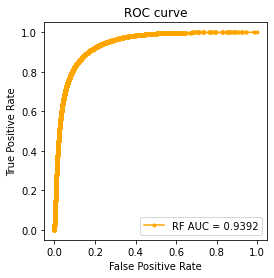

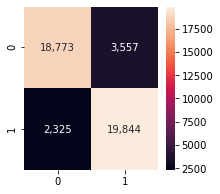

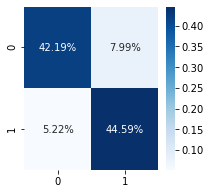

In [30]:
test_acc = evaluate_accuracy(test_iter,net)
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = pred(test_iter, net)
print(classification_report(test_label, y_pred))

# AUC
probs = np.array(pred_prob(test_iter, net))[:, 1]

rf_auc = roc_auc_score(test_label, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model81
rf_fpr, rf_tpr, _ = roc_curve(test_label, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()